In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import json
from collections import Counter
import matplotlib.pyplot as plt
import random
import re
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import os

In [2]:
file_path = "/content/TVs-all-merged.json"
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

In [3]:
print("Number of products:", len(data))
for model_id, entries in data.items():
    print(f"\nModel ID: {model_id}")
    for entry in entries:
        print(f"  Shop: {entry['shop']}")
        print(f"  Title: {entry['title']}")
        print(f"  Features: {entry['featuresMap']}")
        break

流式输出内容被截断，只能显示最后 5000 行内容。

Model ID: 65L7300U
  Shop: bestbuy.com
  Title: Toshiba 65" Class 6412" Diag. LED 1080p 240Hz Smart HDTV 65L7300U - Best Buy
  Features: {'Remote Control Type': 'Universal', 'Screen Size Class': '65"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'Yes', 'Width': '57-9/10"', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '022265277799', 'Screen Size (Measured Diagonally)': '64-1/2"', 'Mount Bracket/VESA Pattern': '400mm x 200mm', 'PC Inputs': '1', 'Aspect Ratio': '16:9', 'Media Card Slot': 'No', 'Weight': '79.8 lbs. with stand (74.1 lbs. without)', 'Vertical Resolution': '1080p', 'Composite Inputs': '1', 'HDMI Inputs': '4', 'Maximum Resolution': '1920 x 1080', 'Screen Refresh Rate': '240Hz', 'Product Height (with stand)': '36-9/10"', 'Product Depth (without stand)': '2-9/10"', 'Warranty Terms - Labor': '1 year limited', 'Warranty Terms - Parts': '1 year limited', 'Product Height (w

In [4]:
example_product = list(data.keys())[0]
example_features = data[example_product][0]['featuresMap']
print("Example product features:")
for feature, value in example_features.items():
    print(f"  {feature}: {value}")

Example product features:
  Screen Size Class: 29"
  DVI Inputs: 0
  ENERGY STAR Certified: Yes
  Ethernet Port: No
  Sleep Timer: Yes
  Width: 27 inches
  USB Port: Yes
  TV Type: LED Flat-Panel
  V-Chip: Yes
  Component Video Inputs: 1
  UPC: 609585230651
  Screen Size (Measured Diagonally): 28-1/2"
  Mount Bracket/VESA Pattern: 100mm x 100mm
  PC Inputs: 1
  Aspect Ratio: 4:3 and 16:9
  Audio Outputs: 1
  Sound Leveler: Yes
  Media Card Slot: No
  Weight: 12.1 lbs. with stand (10.6 lbs. without)
  Vertical Resolution: 720p
  Composite Inputs: 1
  Brightness: 270 cd/mÂ²
  Watts/Channel: 8
  HDMI Inputs: 3
  Maximum Resolution: 1366 x 768
  Screen Refresh Rate: 60Hz
  Product Height (with stand): 18-3/8"
  Product Depth (without stand): 2-5/8"
  Warranty Terms - Labor: 1 year
  Warranty Terms - Parts: 1 year
  Estimated Yearly Operating Cost: $6
  Product Height (without stand): 16-7/8"
  Simulated Surround: Yes
  Product Depth (with stand): 7-3/8"
  Energy Consumption (kWh/year): 51


## Feature Representation

### First of all, exam which attributes are most common available across the dataset.

In [5]:
feature_counter = Counter()

for model_id, entries in data.items():
    for entry in entries:
        features = entry.get('featuresMap', {})
        feature_counter.update(features.keys())

sorted_features = sorted(feature_counter.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Most Common Features in featuresMap:")
for feature, count in sorted_features[:10]:
    print(f"{feature}: {count} occurrences")

total_data_points = sum(len(entries) for entries in data.values())
print("\nTotal Data Points:", total_data_points)

print("\nCoverage Percentage of Top 10 Features:")
for feature, count in sorted_features[:10]:
    coverage = (count / total_data_points) * 100
    print(f"{feature}: {coverage:.2f}%")

Top 10 Most Common Features in featuresMap:
Maximum Resolution: 1058 occurrences
Aspect Ratio: 922 occurrences
Brand: 867 occurrences
UPC: 773 occurrences
V-Chip: 757 occurrences
Screen Size (Measured Diagonally): 735 occurrences
USB Port: 728 occurrences
TV Type: 726 occurrences
Vertical Resolution: 716 occurrences
Screen Size Class: 712 occurrences

Total Data Points: 1624

Coverage Percentage of Top 10 Features:
Maximum Resolution: 65.15%
Aspect Ratio: 56.77%
Brand: 53.39%
UPC: 47.60%
V-Chip: 46.61%
Screen Size (Measured Diagonally): 45.26%
USB Port: 44.83%
TV Type: 44.70%
Vertical Resolution: 44.09%
Screen Size Class: 43.84%


### Then, use the "Title","Brand",and "Maximum Resolution"to build unique feature representations

In [6]:
possible_brands = [
    "Samsung", "Sony", "LG", "Panasonic", "Sharp", "Toshiba", "Philips",
    "Vizio", "Hisense", "JVC", "RCA", "Insignia", "Sanyo", "Haier", "Epson"
]

In [20]:
titles = []
brands = []
resolutions = []
webshops = []
labels = []

for model_id, entries in data.items():
    for entry in entries:

        features_map = entry.get("featuresMap", {})
        if "Brand" not in features_map or not features_map["Brand"]:

            title = entry.get("title", "").lower()
            detected_brand = next((brand for brand in possible_brands if brand.lower() in title), "Unknown")

            features_map["Brand"] = detected_brand
            entry["featuresMap"] = features_map

        title = entry.get('title', "")
        titles.append(title)

        brand = entry.get('featuresMap', {}).get('Brand', "Unknown")
        brands.append(brand)

        webshop = entry.get('shop', "Unknown")
        webshops.append(webshop)

        resolution_str = entry.get('featuresMap', {}).get('Maximum Resolution', "0x0")
        try:
            width, height = map(int, resolution_str.lower().replace(" ", "").split("x"))
            resolution = width * height
        except ValueError:
            resolution = 0
        resolutions.append(resolution)

        labels.append(model_id)

In [21]:
print("Sample Titles:", titles[:5])
print("Sample Brands:", brands[:5])
print("Sample Screen Sizes:", resolutions[:5])
print("Sample Labels:", labels[:5])
print("Sample Webshops:", webshops[:5])

Sample Titles: ['Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy', 'Newegg.com - SuperSonic 32" 720p LED HDTV SC-3211', 'Sharp AQUOS 90" Class 90" Diag. LED 1080p 120Hz Smart 3D HDTV LC-90LE657U - Best Buy', 'Philips 2000 Series 39" Class 3858" Diag. LED 1080p 60Hz Smart HDTV 39PFL2908F7 - Best Buy', 'Newegg.com - Sharp Aquos 70" Class (69.5" Diagonal) 1080p 120Hz LED-LCD HDTV - LC70LE550U']
Sample Brands: ['Philips', 'SuperSonic', 'Sharp', 'Philips', 'Sharp']
Sample Screen Sizes: [1049088, 1049088, 2073600, 2073600, 2073600]
Sample Labels: ['29PFL4508/F7', 'SC-3211', 'LC-90LE657U', '39PFL2908/F7', 'LC70LE550U']
Sample Webshops: ['bestbuy.com', 'newegg.com', 'bestbuy.com', 'bestbuy.com', 'newegg.com']


In [22]:
def standardize_hz(text):
    text = re.sub(r'(\d+)\s+Hz', r'\1Hz', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

vectorizer_tfidf = TfidfVectorizer(stop_words=None,preprocessor=lambda x: standardize_hz(x),token_pattern=r'(?u)\b\w+Hz|\b\w+\b')
title_tfidf = vectorizer_tfidf.fit_transform(titles).toarray()

encoder = OneHotEncoder(sparse_output=False)
brand_vectors = encoder.fit_transform(np.array(brands).reshape(-1, 1))

scaler = StandardScaler()
resolution_scaled = scaler.fit_transform(np.array(resolutions).reshape(-1, 1))

final_features = np.hstack([title_tfidf, brand_vectors, resolution_scaled])
print("Final Feature Representation Shape:", final_features.shape)

Final Feature Representation Shape: (1624, 1690)


In [23]:
final_features[:10,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.06807688, 0.        ,
        0.        , 0.        , 0.        , 0.12112076, 0.        ],
       [0.        , 0.        , 0.        , 0.08246837, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.08432114, 0.        ,
        0.        , 0.        , 0.        , 0.15002216, 0.        ],
       [0.        , 0.        , 0.        , 0.1233779 , 0.        ,
        0.        , 0.        , 0.        , 0.219511  , 0.        ],
       [0.        , 0.        , 0.        , 0.20836072, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [24]:
pca = PCA(n_components=0.95)
final_features_pca = pca.fit_transform(final_features)
print("Reduced Feature Representation Dimension:", final_features_pca.shape)

Reduced Feature Representation Dimension: (1624, 582)


In [25]:
final_features_pca[:10,:10]

array([[-1.43189073e-01, -1.07733848e-01, -2.96310101e-01,
        -8.95731772e-02,  1.28764314e-02, -5.67251958e-02,
        -2.22606533e-02,  1.10772057e-01, -6.02434248e-01,
        -6.04095267e-01],
       [-1.61814452e-01, -1.14486325e-01, -2.37652595e-01,
        -5.95415306e-02, -7.76122491e-03, -2.14768518e-02,
        -7.14648755e-03,  5.54195784e-02, -1.74169954e-01,
        -4.88112311e-02],
       [ 7.79847108e-01,  2.86461463e-02, -3.74192184e-01,
        -2.33509732e-01, -6.00567917e-01,  6.75486853e-01,
        -9.84219174e-02, -2.18455839e-02,  9.71292618e-02,
         3.56615727e-02],
       [ 7.73271443e-01,  3.48999501e-02, -2.91786055e-01,
        -9.35842463e-02,  2.92776171e-02, -5.36645679e-02,
        -7.50234340e-03,  7.76645924e-02, -5.51780570e-01,
        -5.97720860e-01],
       [ 7.77840767e-01,  1.79858114e-02, -3.69180679e-01,
        -2.45619487e-01, -6.11023367e-01,  6.85024494e-01,
        -1.10880272e-01, -3.24886935e-02,  6.30355383e-02,
        -3.

## LSH with cosine similarity

## Generate candidates

In [28]:
def generate_candidates(final_features_pca, b):

    signature_vector_size = final_features_pca.shape[1]
    r = signature_vector_size // b

    if b * r != signature_vector_size:
        raise ValueError(f"b ({b}) must divide signature_vector_size ({signature_vector_size}) evenly")

    hash_tables = [{} for _ in range(b)]
    np.random.seed(42)
    hash_planes = [np.random.randn(r, final_features_pca.shape[1]) for _ in range(b)]

    for idx, vector in enumerate(final_features_pca):
        for i in range(b):
            projections = np.dot(hash_planes[i], vector)
            hash_code = ''.join(['1' if p > 0 else '0' for p in projections])
            bucket = hash_tables[i].setdefault(hash_code, [])
            bucket.append(idx)

    candidate_pairs = set()
    for table in hash_tables:
        for bucket in table.values():
            if len(bucket) > 1:
                for pair in combinations(bucket, 2):
                    candidate_pairs.add(tuple(sorted(pair)))

    return r, candidate_pairs

## Duplicate detection using cosine similarity

In [32]:
def is_duplicate(pair, combined_features, similarity_threshold=0.7):
    idx1, idx2 = pair
    feature_vector_1 = combined_features[idx1].reshape(1, -1)
    feature_vector_2 = combined_features[idx2].reshape(1, -1)

    similarity = cosine_similarity(feature_vector_1, feature_vector_2)[0][0]

    return similarity >= similarity_threshold

## Define Clustering

In [33]:
thresholds = [0.75,1,1.5]

In [34]:
def evaluate_clustering_with_bootstrap(generated_features, labels, num_bootstraps=5, distance_threshold=thresholds):
    best_results = []
    iteration_result = []

    for m in range(num_bootstraps):
      for threshold in thresholds:

        indices = np.arange(len(generated_features))
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_features = generated_features[bootstrap_indices]
        bootstrap_labels = [labels[i] for i in bootstrap_indices]

        clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, metric='euclidean', linkage='ward')
        cluster_labels = clustering_model.fit_predict(bootstrap_features)

        cluster_map = defaultdict(list)
        for idx, cluster_label in enumerate(cluster_labels):
            cluster_map[cluster_label].append(idx)

        clustered_pairs = set()
        for cluster in cluster_map.values():
            if len(cluster) > 1:
                for i, j in combinations(cluster, 2):
                    clustered_pairs.add(tuple(sorted((bootstrap_indices[i], bootstrap_indices[j]))))

        true_duplicates = set()
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(bootstrap_labels):
            label_to_indices[label].append(idx)

        for indices in label_to_indices.values():
            if len(indices) > 1:
                for i, j in combinations(indices, 2):
                    true_duplicates.add(tuple(sorted((bootstrap_indices[i], bootstrap_indices[j]))))

        num_duplicates_found = len(clustered_pairs.intersection(true_duplicates))
        num_comparisons_made = len(clustered_pairs)
        total_duplicates = len(true_duplicates)
        total_possible_comparisons = (len(labels) * (len(labels) - 1)) / 2

        pair_quality = num_duplicates_found / num_comparisons_made if num_comparisons_made > 0 else 0
        pair_completeness = num_duplicates_found / total_duplicates if total_duplicates > 0 else 0

        fraction_of_comparisons = num_comparisons_made / total_possible_comparisons if total_possible_comparisons > 0 else 0

        if pair_quality + pair_completeness > 0:
            f1_measure_pairs = 2 * (pair_quality * pair_completeness) / (pair_quality + pair_completeness)
        else:
            f1_measure_pairs = 0

        if pair_quality + pair_completeness + fraction_of_comparisons > 0:
            f1_star = 3 * (pair_quality * pair_completeness * fraction_of_comparisons) / (pair_quality + pair_completeness + fraction_of_comparisons)
        else:
            f1_star = 0

        iteration_result.append(
            {"Bootstrap": m,
             "Threshold": threshold,
             "PQ":pair_quality,
             "PC":pair_completeness,
             "F1":f1_measure_pairs,
             "F1*":f1_star,
             "Fractions":fraction_of_comparisons
            })
    iteration_result_df = pd.DataFrame(iteration_result)
    bestf1_results_df = iteration_result_df.loc[iteration_result_df.groupby("Bootstrap")['F1'].idxmax()]
    best_results = pd.concat([bestf1_results_df,pd.DataFrame({"Bootstrap": ["Average"],
                                    "Threshold": ["Optimal"],
                                    "PQ":[bestf1_results_df["PQ"].mean()],
                                    "PC":[bestf1_results_df["PC"].mean()],
                                    "F1": [bestf1_results_df['F1'].mean()],
                                    "F1*":[bestf1_results_df["F1*"].mean()],
                                    "Fractions":[bestf1_results_df["Fractions"].mean()]
                                                               })])

    return best_results

## Transitivity

In [35]:
def resolve_transitivity(candidate_pairs):
    G = nx.Graph()
    G.add_edges_from(candidate_pairs)
    clusters = list(nx.connected_components(G))
    return clusters

## Implement

In [39]:
b_list = [1,6,97,194,582]
similarity = [0.4,0.6,0.8]

In [40]:
def  evaluate_performance(b, thresholds,similarity):

      results = []

      for brand in set(brands):

          brand_indices = [i for i, d in enumerate(brands) if d == brand]

          webshop_to_indices = {}
          for i in brand_indices:
              webshop = webshops[i]
              if webshop not in webshop_to_indices:
                  webshop_to_indices[webshop] = []
              webshop_to_indices[webshop].append(i)

          webshop_combinations = list(itertools.combinations(webshop_to_indices.keys(), 2))

          for webshop_1, webshop_2 in webshop_combinations:

              current_combined_indices = webshop_to_indices[webshop_1] + webshop_to_indices[webshop_2]
              current_combined_features = final_features_pca[current_combined_indices, :]

              if len(current_combined_features) > 1:
                for b in b_list:
                  for sim in similarity:
                    result_1 = []
                    result_3 = []
                    r, candidate_pairs = generate_candidates(current_combined_features, b)

                    candidate_pairs_mapped = [(current_combined_indices[pair[0]], current_combined_indices[pair[1]]) for pair in candidate_pairs]


                    current_duplicate_pairs = [(pair[0], pair[1]) for pair in candidate_pairs if is_duplicate(pair, current_combined_features,similarity_threshold=sim)]

                    if len(current_duplicate_pairs) > 0:
                      result_1.append({"Brand":brand,
                                    "Webshop1&Webshop2":webshop_1+"&"+webshop_2,
                                    "b":b,
                                    "r":r,
                                    "Similarity_threshold":sim}
                                    )
                      filtered_indices = list(set([index for pair in current_duplicate_pairs for index in pair]))
                      filtered_features = current_combined_features[filtered_indices, :]

                      result_2 = evaluate_clustering_with_bootstrap(
                                  generated_features = filtered_features, labels = [labels[i] for i in filtered_indices], distance_threshold=thresholds
                              )

                      current_clusters = resolve_transitivity(current_duplicate_pairs)
                      cluster_count = len(current_clusters)

                      result_3.append({"Clusters":cluster_count,
                                      "Duplicate_pair":len(current_duplicate_pairs),
                                      }
                      )
                    else:
                      continue

                    result_1_df = pd.DataFrame(result_1)
                    result_1_repeated = pd.concat([result_1_df] * len(result_2), ignore_index=True)
                    combined_1_2 = pd.concat([result_2.reset_index(drop=True), result_1_repeated.reset_index(drop=True)], axis=1)

                    result_3_df = pd.DataFrame(result_3)
                    result_3_repeated = pd.concat([result_3_df] * len(result_2), ignore_index=True)
                    iteration_result = pd.concat([combined_1_2.reset_index(drop=True), result_3_repeated.reset_index(drop=True)], axis=1)

                    results.append(iteration_result)

      final_df = pd.concat(results,ignore_index=True)

      return final_df

In [41]:
final_df = evaluate_performance(b_list,thresholds,similarity)

In [43]:
final_df.head(20)

,Bootstrap,Threshold,PQ,PC,F1,F1*,Fractions,Brand,Webshop1&Webshop2,b,r,Similarity_threshold,Clusters,Duplicate_pair
0,0,0.75,1.0,1.0,1.0,1.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
1,1,1.5,1.0,1.0,1.0,1.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
2,2,0.75,0.0,0.0,0.0,0.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
3,3,0.75,0.0,0.0,0.0,0.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
4,4,0.75,1.0,1.0,1.0,1.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
5,Average,Optimal,0.6,0.6,0.6,0.6,1.0,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
6,0,0.75,1.0,1.0,1.0,1.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.6,1,1
7,1,1.5,1.0,1.0,1.0,1.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.6,1,1
8,2,0.75,0.0,0.0,0.0,0.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.6,1,1
9,3,0.75,0.0,0.0,0.0,0.0,1.0,Coby,newegg.com&bestbuy.com,1,582,0.6,1,1


In [44]:
final_df.to_csv('final_df.csv', index=False)

# Visualization

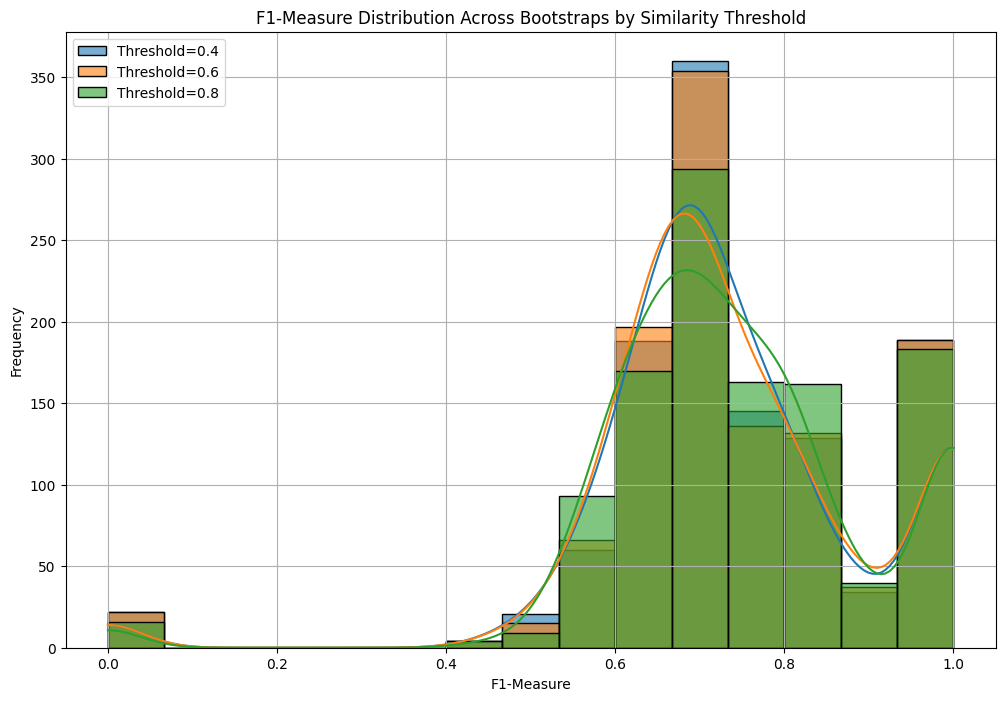

In [92]:
plt.figure(figsize=(12, 8))
for threshold in similarity:
    threshold_subset = final_df[final_df['Similarity_threshold'] == threshold]
    sns.histplot(
        threshold_subset['F1'],
        label=f"Threshold={threshold}",
        kde=True, bins=15, alpha=0.6
    )
plt.title("F1-Measure Distribution Across Bootstraps by Similarity Threshold")
plt.xlabel("F1-Measure")
plt.ylabel("Frequency")
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.savefig('F1-Measure Distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

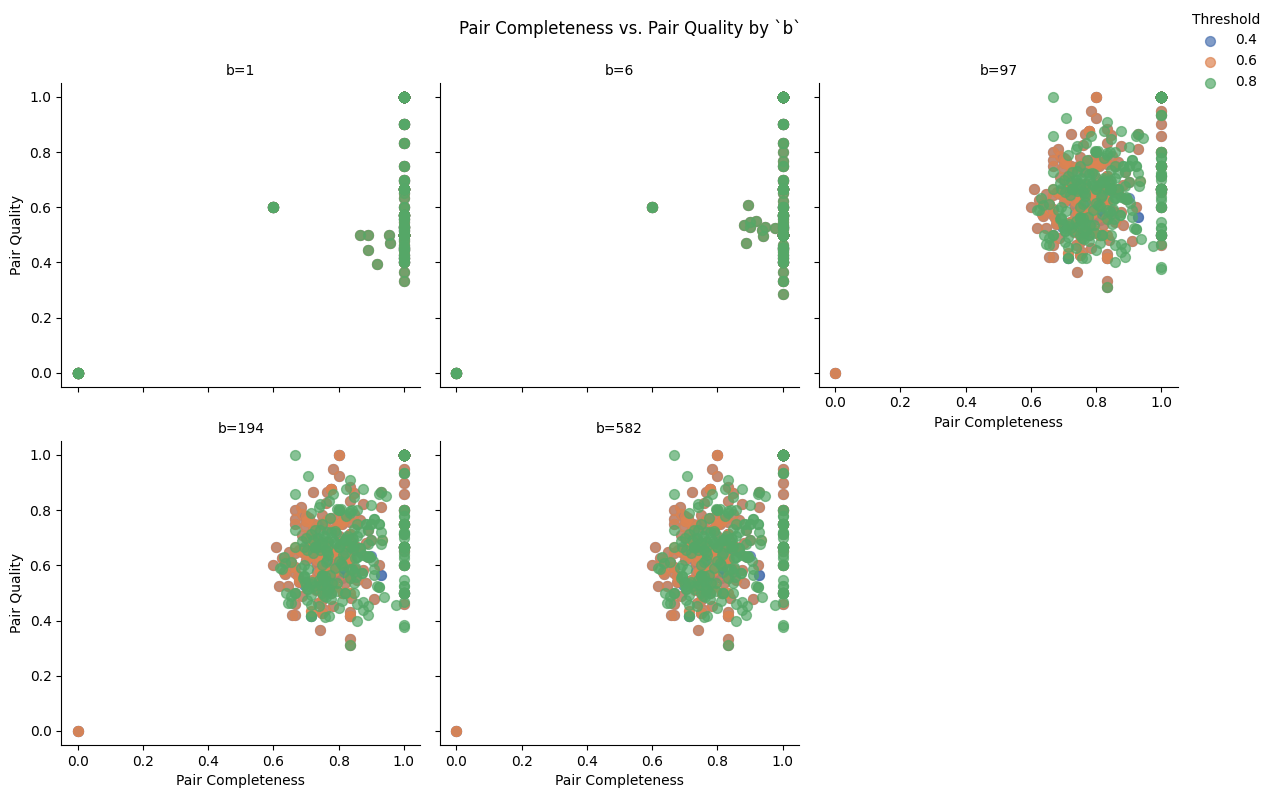

In [102]:
g = sns.FacetGrid(final_df, col="b", hue="Similarity_threshold", palette="deep", col_wrap=3, height=4)
g.map(plt.scatter, "PC", "PQ", alpha=0.7, s=50)
g.add_legend(title="Threshold", loc='upper right')
g.set_titles("b={col_name}")
g.set_axis_labels("Pair Completeness", "Pair Quality")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Pair Completeness vs. Pair Quality by `b`")
plt.savefig('Pair Completeness vs. Pair Quality by `b`.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [45]:
average_df = final_df[(final_df["Bootstrap"]=="Average")]
average_df

,Bootstrap,Threshold,PQ,PC,F1,F1*,Fractions,Brand,Webshop1&Webshop2,b,r,Similarity_threshold,Clusters,Duplicate_pair
5,Average,Optimal,0.6,0.6,0.6,0.600000,1.00,Coby,newegg.com&bestbuy.com,1,582,0.4,1,1
11,Average,Optimal,0.6,0.6,0.6,0.600000,1.00,Coby,newegg.com&bestbuy.com,1,582,0.6,1,1
17,Average,Optimal,0.6,0.6,0.6,0.600000,1.00,Coby,newegg.com&bestbuy.com,1,582,0.8,1,1
23,Average,Optimal,0.6,0.6,0.6,0.600000,1.00,Coby,newegg.com&bestbuy.com,6,97,0.4,1,1
29,Average,Optimal,0.6,0.6,0.6,0.600000,1.00,Coby,newegg.com&bestbuy.com,6,97,0.6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413,Average,Optimal,1.0,1.0,1.0,0.194805,0.14,Seiki,newegg.com&bestbuy.com,194,3,0.6,1,10
3419,Average,Optimal,1.0,1.0,1.0,0.194805,0.14,Seiki,newegg.com&bestbuy.com,194,3,0.8,2,4
3425,Average,Optimal,1.0,1.0,1.0,0.194805,0.14,Seiki,newegg.com&bestbuy.com,582,1,0.4,1,10
3431,Average,Optimal,1.0,1.0,1.0,0.194805,0.14,Seiki,newegg.com&bestbuy.com,582,1,0.6,1,10


In [91]:
average_df.to_csv('average_df.csv', index=False)

In [ ]:
metrics = ['PQ', 'PC', 'F1', 'F1*']

<ipython-input-134-c7eb394d49e5>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_df, x='b', y='Score', hue='Metric', dodge=True, palette='viridis', ci=None)


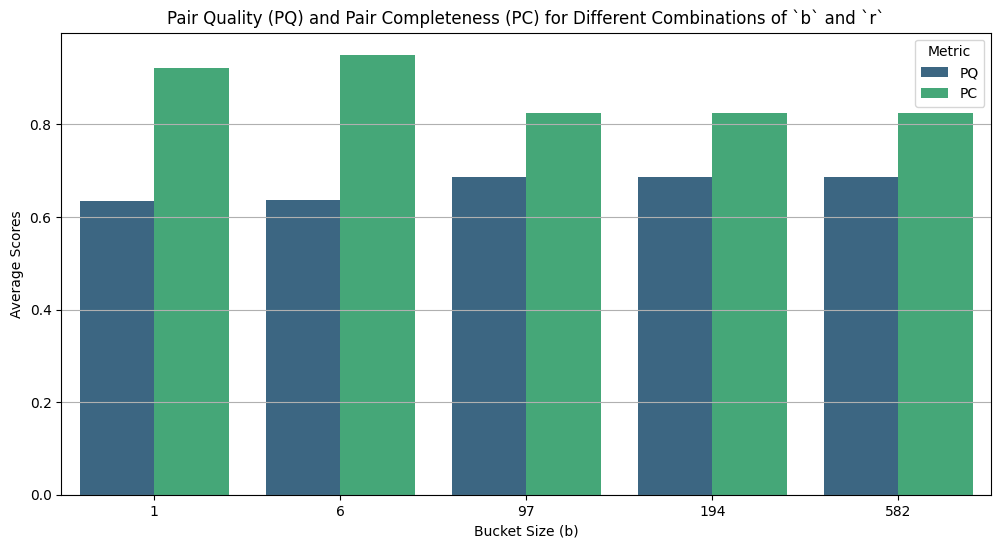

In [134]:
grouped_df = final_df.groupby(['b', 'r'])[['PQ', 'PC']].mean().reset_index()

melted_df = grouped_df.melt(id_vars=['b', 'r'], value_vars=['PQ', 'PC'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='b', y='Score', hue='Metric', dodge=True, palette='viridis', ci=None)
plt.title("Pair Quality (PQ) and Pair Completeness (PC) for Different Combinations of `b` and `r`")
plt.xlabel("Bucket Size (b)")
plt.ylabel("Average Scores")
plt.legend(title="Metric", loc='best')
plt.grid(axis='y')
output_file_pdf = "PQ_PC_by_b_and_r.pdf"
plt.savefig(output_file_pdf, format="pdf", bbox_inches="tight")
print(f"Plot saved as PDF: {output_file_pdf}")
plt.show()

In [113]:
example_results = average_df[(average_df["b"] == 97)  & (average_df["Similarity_threshold"] == 0.8)]
example_results

,Bootstrap,Threshold,PQ,PC,F1,F1*,Fractions,Brand,Webshop1&Webshop2,b,r,Similarity_threshold,Clusters,Duplicate_pair,fraction_bin
53,Average,Optimal,0.593463,0.851190,0.698290,0.045722,0.045714,Coby,newegg.com&bestbuy.com,97,6,0.8,4,25,0.000000
107,Average,Optimal,0.716667,1.000000,0.824762,0.116610,0.100000,SunBriteTV,bestbuy.com&newegg.com,97,6,0.8,2,7,0.052632
197,Average,Optimal,0.453065,0.889286,0.597270,0.045307,0.052964,RCA,bestbuy.com&newegg.com,97,6,0.8,3,77,0.052632
287,Average,Optimal,0.585032,0.707099,0.639106,0.012157,0.012818,Sony,bestbuy.com&newegg.com,97,6,0.8,4,358,0.000000
377,Average,Optimal,0.589562,0.789599,0.671141,0.015723,0.015758,Sony,bestbuy.com&amazon.com,97,6,0.8,4,406,0.000000
467,Average,Optimal,0.698135,0.840659,0.757048,0.019941,0.017970,Sony,newegg.com&amazon.com,97,6,0.8,4,176,0.000000
557,Average,Optimal,0.531206,0.714088,0.608626,0.010218,0.011343,Panasonic,bestbuy.com&newegg.com,97,6,0.8,4,612,0.000000
647,Average,Optimal,0.530096,0.744379,0.615447,0.011148,0.012284,Panasonic,bestbuy.com&amazon.com,97,6,0.8,4,593,0.000000
737,Average,Optimal,0.505666,0.763460,0.600024,0.021464,0.024242,Panasonic,newegg.com&amazon.com,97,6,0.8,2,296,0.000000
827,Average,Optimal,0.677311,0.802819,0.734346,0.003780,0.003441,LG,bestbuy.com&newegg.com,97,6,0.8,26,544,0.000000


         Brand  PQ_score  PC_score  F1_measure  F1*_measure
0         Coby  0.593463  0.851190    0.698290     0.045722
1        Haier  0.616111  0.904762    0.727223     0.047944
2      Hisense  0.933333  1.000000    0.960000     0.227251
3          JVC  0.693333  0.933333    0.787302     0.089806
4           LG  0.625658  0.823040    0.709183     0.006369
5    Panasonic  0.522323  0.740642    0.608032     0.014276
6      Philips  0.567900  0.889411    0.679474     0.044956
7          RCA  0.453065  0.889286    0.597270     0.045307
8      Samsung  0.526227  0.780990    0.627529     0.004216
9       Sansui  0.750000  0.883333    0.787778     0.085934
10       Sanyo  0.653333  1.000000    0.786190     0.099049
11       Seiki  1.000000  1.000000    1.000000     0.194805
12       Sharp  0.668852  0.862419    0.746528     0.061845
13        Sony  0.624243  0.779119    0.689099     0.015940
14  SunBriteTV  0.716667  1.000000    0.824762     0.116610
15     Toshiba  0.763060  0.783672    0.

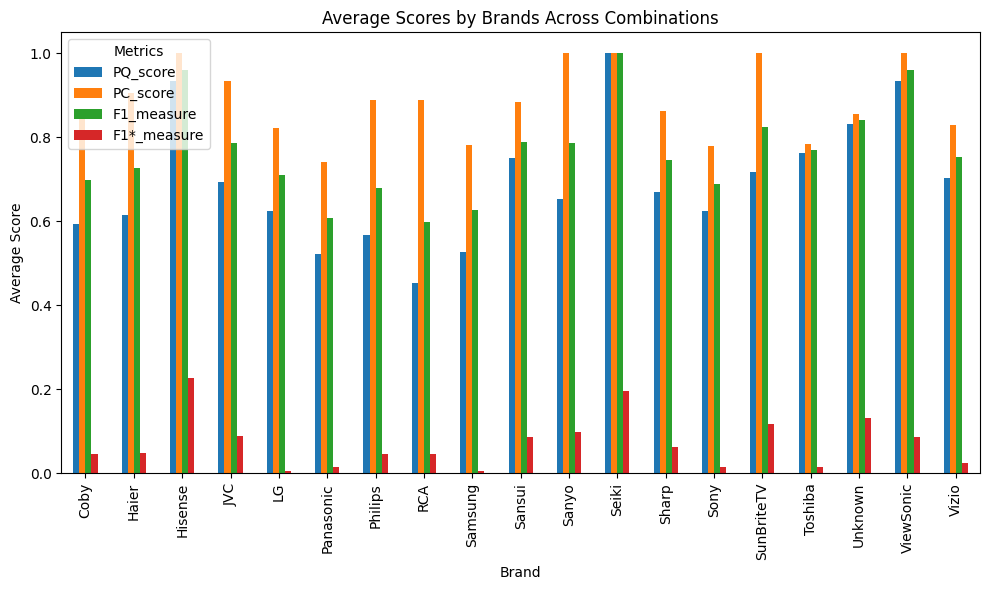

In [137]:
brand_PQ = example_results.groupby('Brand')['PQ'].mean()
brand_PC = example_results.groupby('Brand')['PC'].mean()
brand_F1 = example_results.groupby('Brand')['F1'].mean()
brand_F1_star = example_results.groupby('Brand')['F1*'].mean()

example_averages = pd.DataFrame({
    'PQ_score': brand_PQ,
    'PC_score': brand_PC,
    'F1_measure': brand_F1,
    'F1*_measure': brand_F1_star
}).reset_index()
print(example_averages)

example_averages.set_index('Brand').plot(kind='bar', figsize=(10, 6))

plt.title('Average Scores by Brands Across Combinations')
plt.ylabel('Average Score')
plt.xlabel('Brand')
plt.legend(title='Metrics', loc='upper left')
plt.tight_layout()
output_file_pdf = "Average Scores by Brands Across Combinations.pdf"
plt.savefig(output_file_pdf, format="pdf", bbox_inches="tight")
print(f"Plot saved as PDF: {output_file_pdf}")
plt.show()

Plot saved as PDF: Performance for each brand across different Combinations.pdf


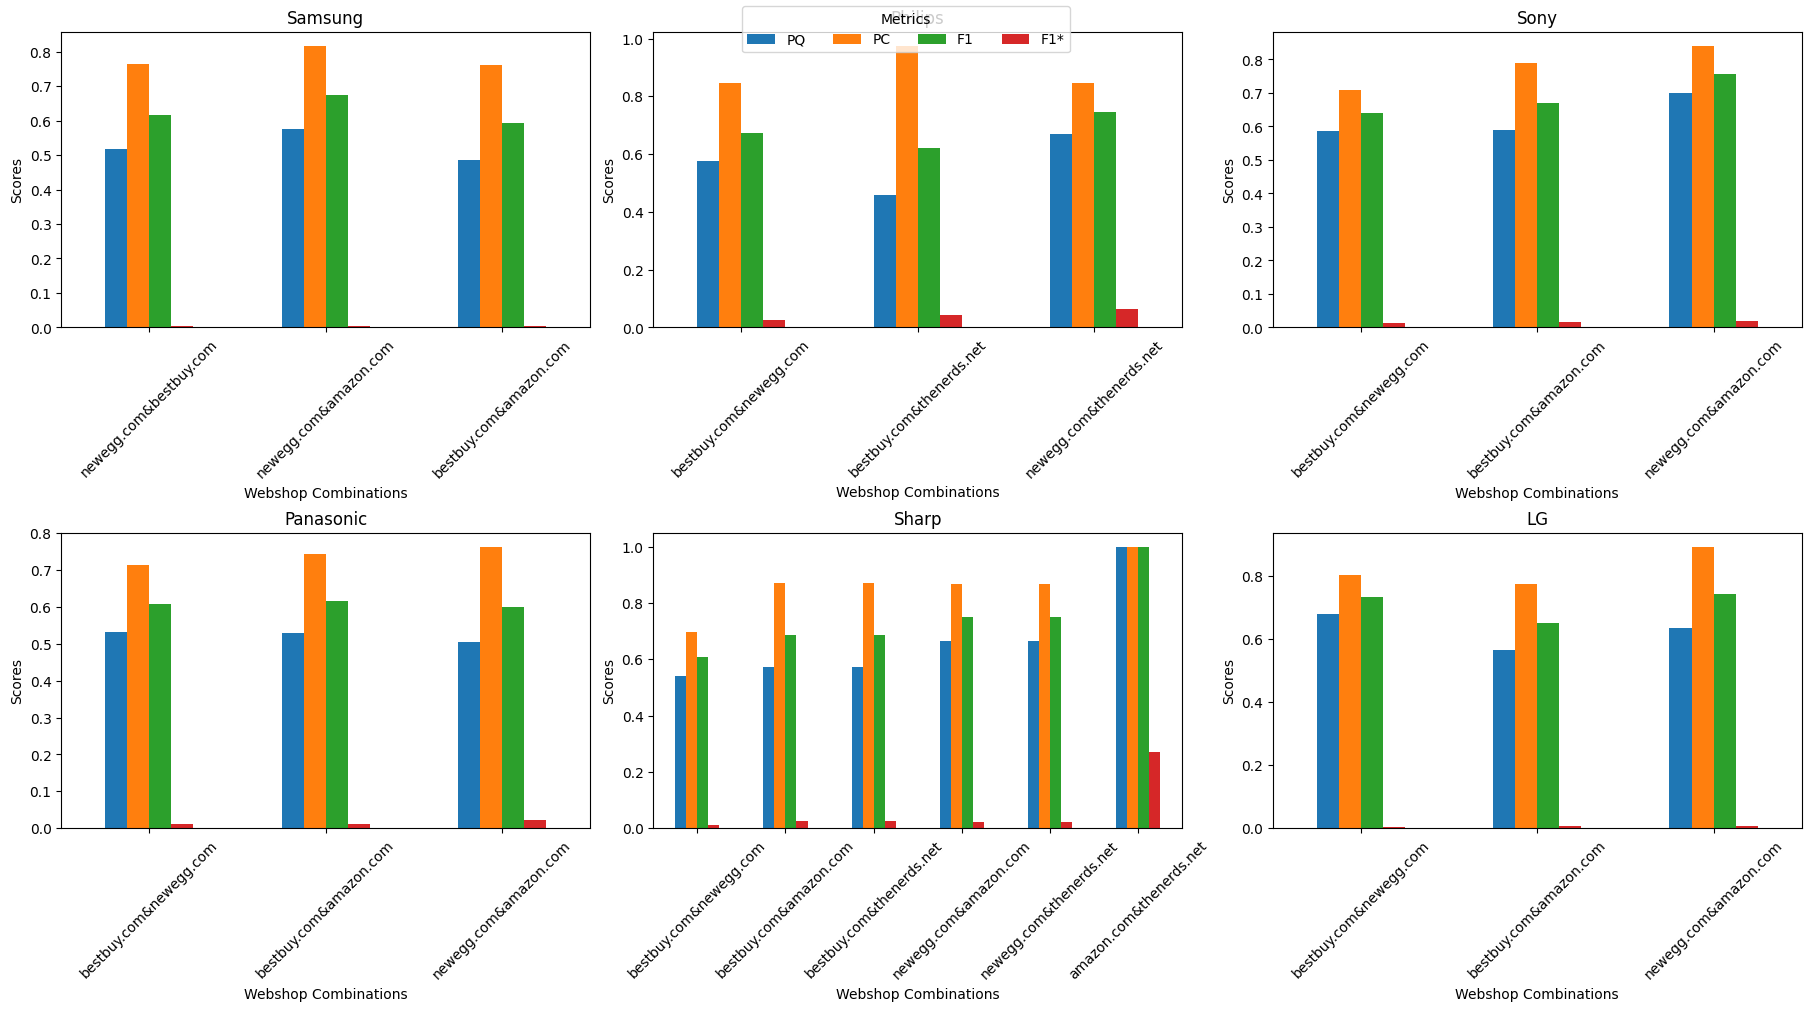

In [138]:
example_brands = ["Samsung", "Philips", "Sony", "Panasonic", "Sharp", "LG"]
filtered_results = example_results[example_results['Brand'].isin(example_brands)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

for i, brand in enumerate(example_brands):
    brand_data = filtered_results[filtered_results['Brand'] == brand]
    if not brand_data.empty:
        brand_data.plot(
            x='Webshop1&Webshop2',
            y=['PQ', 'PC', 'F1', 'F1*'],
            kind='bar',
            ax=axes[i],
            legend=False,
            title=f'{brand}'
        )
        axes[i].set_xlabel('Webshop Combinations')
        axes[i].set_ylabel('Scores')
        axes[i].tick_params(axis='x', rotation=45)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title="Metrics")
output_file_pdf = "Performance for each brand across different Combinations.pdf"
plt.savefig(output_file_pdf, format="pdf", bbox_inches="tight")
print(f"Plot saved as PDF: {output_file_pdf}")
plt.show()